In [1]:
import pandas

In [2]:
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.interfaces.io as nio
import nipype.interfaces.fsl as fsl

In [5]:
def get_physiological_regressors(phys_log, fmri_data, nr_dummies=4, threshold=1.5, sample_rate=500, TR=1.2, extra_TRs=2.):
    import pandas
    import nibabel as nb
    import os
    from matplotlib.backends.backend_pdf import PdfPages
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig_fn = os.path.abspath('physlog_checks.pdf')
    pp = PdfPages(fig_fn)
    
    
    d = pandas.read_csv(phys_log, sep='\s+', header=4)
    d.columns = d.columns[1:].tolist() + [np.nan]
    d = d.fillna(method='backfill')
    
    gradient_signal = d.ix[:,['gx', 'gy', 'gz']].astype(float).sum(1)
    gradient_signal = (gradient_signal-gradient_signal.mean()) / gradient_signal.std()
    
    fmri_data = nb.load(fmri_data)
    nr_slices = fmri_data.shape[2]
    nr_TRs = fmri_data.shape[-1]
    
#     print nr_slices, nr_TRs

    x = np.arange(gradient_signal.shape[0])
    slice_times = x[np.array(np.diff(np.array(gradient_signal>threshold, dtype=int))==1, dtype=bool)]+1
    
    if slice_times.shape[0] > (nr_TRs*nr_slices*2):
        slice_times = slice_times[0::2]
    
#     print slice_times
    
    gap = np.where(np.diff(slice_times) > ((nr_TRs / float(nr_slices))*15.0))[0][-1]
    
#     print np.where(np.diff(slice_times) > ((nr_TRs / float(nr_slices))*1.0)), gap

    # dummy slices and volumes:
    dummy_slice_indices = (np.arange(slice_times.shape[0]) > gap) * (np.arange(slice_times.shape[0]) < gap + (nr_dummies * nr_slices))
    dummy_slices = np.arange(x.shape[0])[dummy_slice_indices]
    dummy_volumes = dummy_slices[0::nr_slices]

    # scans slices and volumes:
    scan_slice_indices = (np.arange(slice_times.shape[0]) > dummy_slices[-1])
    scan_slices = np.arange(x.shape[0])[scan_slice_indices][0:(nr_TRs*nr_slices)]
    scan_volumes = scan_slices[0:(nr_TRs*nr_slices):nr_slices]
    
    scan_slices_timecourse = np.zeros(x.shape[0])
    scan_slices_timecourse[slice_times[scan_slices]] = 1
    scan_volumes_timecourse = np.zeros(x.shape[0])
    scan_volumes_timecourse[slice_times[scan_volumes]] = 1
    dummies_volumes_timecourse = np.zeros(x.shape[0])
    dummies_volumes_timecourse[slice_times[dummy_volumes]] = 1
    
    assert(scan_volumes_timecourse.sum() == nr_TRs)
    last_slice = scan_volumes_timecourse.shape[0] - np.argmax(scan_volumes_timecourse[::-1])
    print last_slice
   
    
    # plot:
    plot_timewindow = [	np.arange(0, slice_times[dummy_volumes[-1]]+(4*sample_rate)),
                        np.arange(slice_times[scan_slices[-1]]-(8*sample_rate), x.shape[0]),
                        np.arange(slice_times[scan_slices[-10]], slice_times[scan_slices[-5]]),
                        ]

    for i, times in enumerate(plot_timewindow):
        f = plt.figure(figsize = (15,3))
        s = f.add_subplot(111)
        plt.plot(x[times], gradient_signal[times], label='summed gradient signal (x, y, z)')
        if i in (0,1):
            plt.plot(x[times], dummies_volumes_timecourse[times]*threshold*1.5, 'k', lw=3, label='dummies')
            plt.plot(x[times], scan_volumes_timecourse[times]*threshold*1.5, 'g', lw=3, label='triggers')
            plt.axvline(last_slice + sample_rate * TR * extra_TRs, c='r')
        
        if i == 2:
            plt.plot(x[times], scan_slices_timecourse[times]*threshold*1.5, 'g', lw=1, label='slices')
        plt.axhline(threshold, color='r', ls='--', label='threshold')
        s.set_title('summed gradient signal (x, y, z) -- nr volumes = {}'.format(sum(scan_volumes_timecourse)))
        s.set_xlabel('samples, {}Hz'.format(sample_rate))
        plt.ylim((0,threshold*1.5))
        
        delta = times[-1] - times[0]
        
        plt.xlim(times[0] - .1 * delta, times[-1] + .1* delta)
        leg = s.legend(fancybox = True)
        leg.get_frame().set_alpha(0.5)
        if leg:
            for t in leg.get_texts():
                t.set_fontsize('small')    # the legend text fontsize
            for (j, l) in enumerate(leg.get_lines()):
                l.set_linewidth(3.5)  # the legend line width

        plt.tight_layout()
        pp.savefig()
        
#     print gradient_signal.values[int(last_slice + sample_rate * TR * extra_TRs):]
    assert((gradient_signal.values[int(last_slice + sample_rate * TR * extra_TRs):] < .1).all())
    
    pp.close()
    
    physio_fn = os.path.abspath('physio.txt')
    
    physio = np.hstack((d.resp.values[:, np.newaxis], d.ppu.values[:, np.newaxis], scan_volumes_timecourse[:, np.newaxis]))
    
    np.savetxt(physio_fn, physio, fmt = '%3.2f', delimiter = '\t')

    
    return fig_fn, physio_fn


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 317401 but corresponding boolean dimension is 317400
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 317401 but corresponding boolean dimension is 8054
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 317401 but corresponding boolean dimension is 8054


316052


('/home/gdholla1/notebooks/2016_daphne/physlog_checks.pdf',
 '/home/gdholla1/notebooks/2016_daphne/physio.txt')

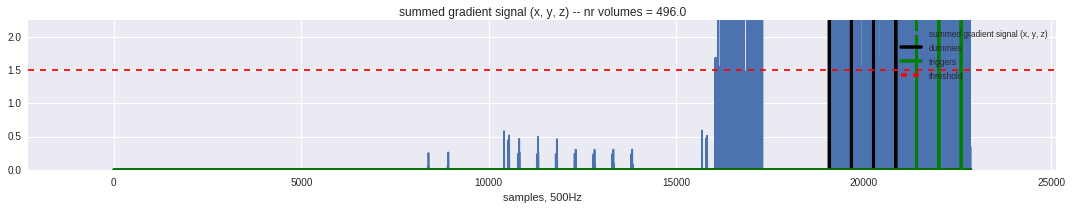

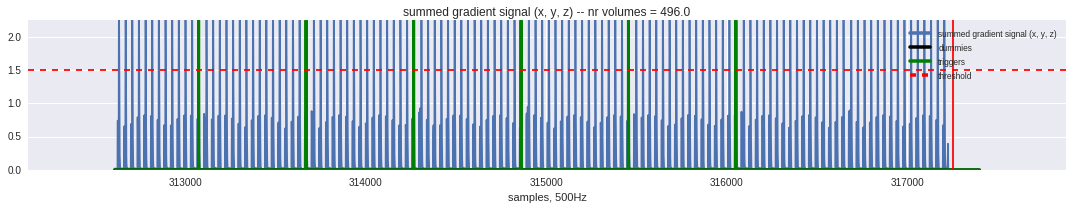

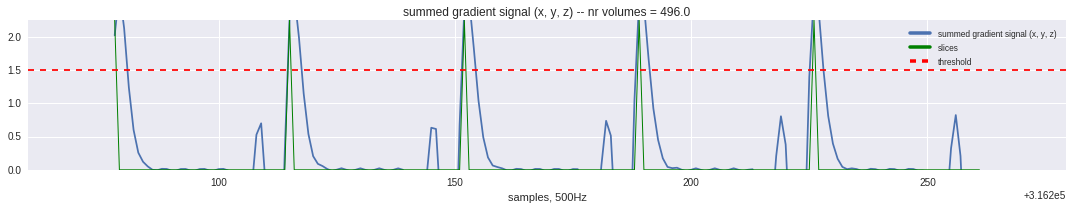

In [22]:
get_physiological_regressors('/home/gdholla1/data/daphne/clean/S13/run1.log',
                             '/home/gdholla1/data/daphne/clean/S13/run1.nii.gz',)

In [19]:
import pandas
import nibabel as nb
import os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np

fig_fn = os.path.abspath('physlog_checks.pdf')
pp = PdfPages(fig_fn)

phys_log = '/home/gdholla1/data/daphne/clean/S07/run3.log'
fmri_data = '/home/gdholla1/data/daphne/clean/S07/run3.nii.gz'
nr_dummies=4 
threshold=1.5
sample_rate=500
TR=1.2
extra_TRs=2.

d = pandas.read_csv(phys_log, sep='\s+', header=4)
d.columns = d.columns[1:].tolist() + [np.nan]
d = d.fillna(method='backfill')

gradient_signal = d.ix[:,['gx', 'gy', 'gz']].astype(float).sum(1)
gradient_signal = (gradient_signal-gradient_signal.mean()) / gradient_signal.std()

fmri_data = nb.load(fmri_data)
nr_slices = fmri_data.shape[2]
nr_TRs = fmri_data.shape[-1]

#     print nr_slices, nr_TRs

x = np.arange(gradient_signal.shape[0])
slice_times = x[np.array(np.diff(np.array(gradient_signal>threshold, dtype=int))==1, dtype=bool)]+1

if slice_times.shape[0] > (nr_TRs*nr_slices*2):
    slice_times = slice_times[0::2]

#     print slice_times

gap = np.where(np.diff(slice_times) > ((nr_TRs / float(nr_slices))*2.5))[0][-1]

#     print np.where(np.diff(slice_times) > ((nr_TRs / float(nr_slices))*1.0)), gap

# dummy slices and volumes:
dummy_slice_indices = (np.arange(slice_times.shape[0]) > gap) * (np.arange(slice_times.shape[0]) < gap + (nr_dummies * nr_slices))
dummy_slices = np.arange(x.shape[0])[dummy_slice_indices]
dummy_volumes = dummy_slices[0::nr_slices]

# scans slices and volumes:
scan_slice_indices = (np.arange(slice_times.shape[0]) > dummy_slices[-1])
scan_slices = np.arange(x.shape[0])[scan_slice_indices][0:(nr_TRs*nr_slices)]
scan_volumes = scan_slices[0:(nr_TRs*nr_slices):nr_slices]

scan_slices_timecourse = np.zeros(x.shape[0])
scan_slices_timecourse[slice_times[scan_slices]] = 1
scan_volumes_timecourse = np.zeros(x.shape[0])
scan_volumes_timecourse[slice_times[scan_volumes]] = 1
dummies_volumes_timecourse = np.zeros(x.shape[0])
dummies_volumes_timecourse[slice_times[dummy_volumes]] = 1

assert(scan_volumes_timecourse.sum() == nr_TRs)
last_slice = scan_volumes_timecourse.shape[0] - np.argmax(scan_volumes_timecourse[::-1])
print last_slice



1492891


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1493801 but corresponding boolean dimension is 1493800
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1493801 but corresponding boolean dimension is 39833
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1493801 but corresponding boolean dimension is 39833


In [15]:
np.diff(slice_times)

682

In [16]:
(nr_TRs / float(nr_slices))*1.0

155.3125

In [1]:
import gzip, pickle as pkl

In [2]:
node = pkl.load(gzip.open('/home/gdholla1/crashdumps/crash-20160520-102438-gdholla1-get_phys_node.a0.pklz'))['node']

In [3]:
#r = node.run()

In [6]:
def get_physiological_regressors(phys_log, fmri_data, nr_dummies=4, threshold=1.5, sample_rate=500, TR=1.2, extra_TRs=2.):
    import pandas
    import nibabel as nb
    import os
    import matplotlib as mpl
    mpl.use('Agg')
    from matplotlib.backends.backend_pdf import PdfPages
    import matplotlib.pyplot as plt
    import numpy as np


    fig_fn = os.path.abspath('physlog_checks.pdf')
    pp = PdfPages(fig_fn)


    d = pandas.read_csv(phys_log, sep='\s+', header=4)
    d.columns = d.columns[1:].tolist() + [np.nan]
    #d = d.fillna(method='backfill')

    gradient_signal = d.ix[:,['gx', 'gy', 'gz']].astype(float).sum(1)
    gradient_signal = (gradient_signal-gradient_signal.mean()) / gradient_signal.std()

    fmri_data = nb.load(fmri_data)
    nr_slices = fmri_data.shape[2]
    nr_TRs = fmri_data.shape[-1]

#     print nr_slices, nr_TRs

    x = np.arange(gradient_signal.shape[0])
    slice_times = x[np.array(np.diff(np.array(gradient_signal>threshold, dtype=int))==1, dtype=bool)]+1

    if slice_times.shape[0] > (nr_TRs*nr_slices*2):
        slice_times = slice_times[0::2]

#     print slice_times

    gap = np.where(np.diff(slice_times) > ((nr_TRs / float(nr_slices))*10.0))[0][-1]

#     print np.where(np.diff(slice_times) > ((nr_TRs / float(nr_slices))*1.0)), gap

    # dummy slices and volumes:
    dummy_slice_indices = (np.arange(slice_times.shape[0]) > gap) * (np.arange(slice_times.shape[0]) < gap + (nr_dummies * nr_slices))
    dummy_slices = np.arange(x.shape[0])[dummy_slice_indices]
    dummy_volumes = dummy_slices[0::nr_slices]

    # scans slices and volumes:
    scan_slice_indices = (np.arange(slice_times.shape[0]) > dummy_slices[-1])
    scan_slices = np.arange(x.shape[0])[scan_slice_indices][0:(nr_TRs*nr_slices)]
    scan_volumes = scan_slices[0:(nr_TRs*nr_slices):nr_slices]

    scan_slices_timecourse = np.zeros(x.shape[0])
    scan_slices_timecourse[slice_times[scan_slices]] = 1
    scan_volumes_timecourse = np.zeros(x.shape[0])
    scan_volumes_timecourse[slice_times[scan_volumes]] = 1
    dummies_volumes_timecourse = np.zeros(x.shape[0])
    dummies_volumes_timecourse[slice_times[dummy_volumes]] = 1

    assert(scan_volumes_timecourse.sum() == nr_TRs)
    last_slice = scan_volumes_timecourse.shape[0] - np.argmax(scan_volumes_timecourse[::-1])
    print last_slice


    # plot:
    plot_timewindow = [ np.arange(0, slice_times[dummy_volumes[-1]]+(4*sample_rate)),
                        np.arange(slice_times[scan_slices[-1]]-(8*sample_rate), x.shape[0]),
                        np.arange(slice_times[scan_slices[-10]], slice_times[scan_slices[-5]]),
                        ]

    for i, times in enumerate(plot_timewindow):
        f = plt.figure(figsize = (15,3))
        s = f.add_subplot(111)
        plt.plot(x[times], gradient_signal[times], label='summed gradient signal (x, y, z)')
        if i in (0,1):
            plt.plot(x[times], dummies_volumes_timecourse[times]*threshold*1.5, 'k', lw=3, label='dummies')
            plt.plot(x[times], scan_volumes_timecourse[times]*threshold*1.5, 'g', lw=3, label='triggers')
            plt.axvline(last_slice + sample_rate * TR * extra_TRs, c='r')

        if i == 2:
            plt.plot(x[times], scan_slices_timecourse[times]*threshold*1.5, 'g', lw=1, label='slices')
        plt.axhline(threshold, color='r', ls='--', label='threshold')
        s.set_title('summed gradient signal (x, y, z) -- nr volumes = {}'.format(sum(scan_volumes_timecourse)))
        s.set_xlabel('samples, {}Hz'.format(sample_rate))
        plt.ylim((0,threshold*1.5))

        delta = times[-1] - times[0]

        plt.xlim(times[0] - .1 * delta, times[-1] + .1* delta)
        leg = s.legend(fancybox = True)
        leg.get_frame().set_alpha(0.5)
        if leg:
            for t in leg.get_texts():
                t.set_fontsize('small')    # the legend text fontsize
            for (j, l) in enumerate(leg.get_lines()):
                l.set_linewidth(3.5)  # the legend line width

        plt.tight_layout()
        pp.savefig()

#     print gradient_signal.values[int(last_slice + sample_rate * TR * extra_TRs):]
    assert((gradient_signal.values[int(last_slice + sample_rate * TR * extra_TRs):] < .1).all())

    pp.close()

    physio_fn = os.path.abspath('physio.txt')

    physio = np.hstack((d.resp.values[:, np.newaxis], d.ppu.values[:, np.newaxis], scan_volumes_timecourse[:, np.newaxis]))

    np.savetxt(physio_fn, physio, fmt = '%3.2f', delimiter = '\t')


    return fig_fn, physio_fn

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2831: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 316501 but corresponding boolean dimension is 316500
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 316501 but corresponding boolean dimension is 8025
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 316501 but corresponding boolean dimension is 8025


315617


('/home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S06/get_phys_node/mapflow/_get_phys_node2/physlog_checks.pdf',
 '/home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S06/get_phys_node/mapflow/_get_phys_node2/physio.txt')

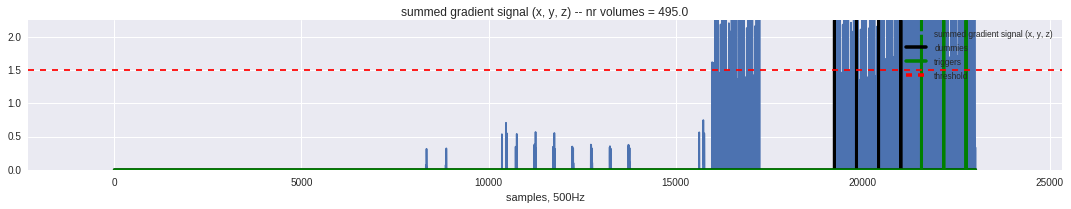

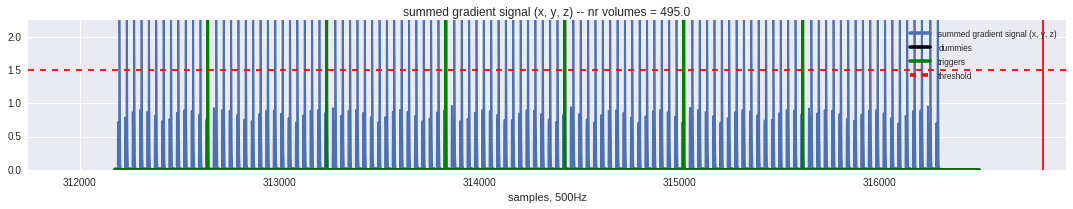

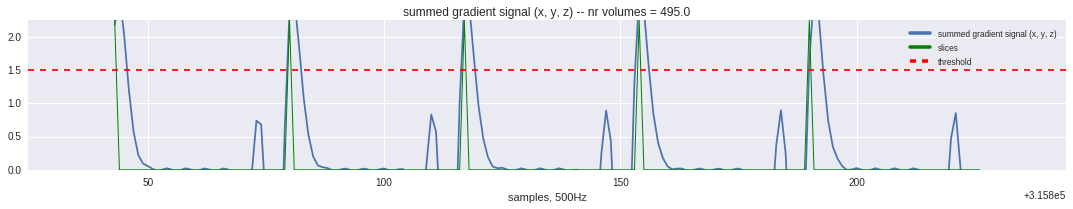

In [7]:
get_physiological_regressors('/home/gdholla1/data/daphne/clean/S06/run1.log',
                             '/home/gdholla1/data/daphne/clean/S06/run1.nii.gz',)

In [11]:
print node.inputs.function_str

def get_physiological_regressors(phys_log, fmri_data, nr_dummies=4, threshold=1.5, sample_rate=500, TR=1.2, extra_TRs=2.):
    import pandas
    import nibabel as nb
    import os
    import matplotlib as mpl
    mpl.use('Agg')
    from matplotlib.backends.backend_pdf import PdfPages
    import matplotlib.pyplot as plt
    import numpy as np


    fig_fn = os.path.abspath('physlog_checks.pdf')
    pp = PdfPages(fig_fn)


    d = pandas.read_csv(phys_log, sep='\s+', header=4)
    d.columns = d.columns[1:].tolist() + [np.nan]
    #d = d.fillna(method='backfill')

    gradient_signal = d.ix[:,['gx', 'gy', 'gz']].astype(float).sum(1)
    gradient_signal = (gradient_signal-gradient_signal.mean()) / gradient_signal.std()

    fmri_data = nb.load(fmri_data)
    nr_slices = fmri_data.shape[2]
    nr_TRs = fmri_data.shape[-1]

#     print nr_slices, nr_TRs

    x = np.arange(gradient_signal.shape[0])
    slice_times = x[np.array(np.diff(np.array(gradient_signal>threshold, dtype=int))==1, dtype=

In [12]:
def get_physiological_regressors(phys_log, fmri_data, nr_dummies=4, threshold=1.5, sample_rate=500, TR=1.2, extra_TRs=2.):
    import pandas
    import nibabel as nb
    import os
    import matplotlib as mpl
    mpl.use('Agg')
    from matplotlib.backends.backend_pdf import PdfPages
    import matplotlib.pyplot as plt
    import numpy as np


    fig_fn = os.path.abspath('physlog_checks.pdf')
    pp = PdfPages(fig_fn)


    d = pandas.read_csv(phys_log, sep='\s+', header=4)
    d.columns = d.columns[1:].tolist() + [np.nan]
    #d = d.fillna(method='backfill')

    gradient_signal = d.ix[:,['gx', 'gy', 'gz']].astype(float).sum(1)
    gradient_signal = (gradient_signal-gradient_signal.mean()) / gradient_signal.std()

    fmri_data = nb.load(fmri_data)
    nr_slices = fmri_data.shape[2]
    nr_TRs = fmri_data.shape[-1]

#     print nr_slices, nr_TRs

    x = np.arange(gradient_signal.shape[0])
    slice_times = x[np.array(np.diff(np.array(gradient_signal>threshold, dtype=int))==1, dtype=bool)]+1

    if slice_times.shape[0] > (nr_TRs*nr_slices*2):
        slice_times = slice_times[0::2]

#     print slice_times

    gap = np.where(np.diff(slice_times) > ((nr_TRs / float(nr_slices))*10.0))[0][-1]

#     print np.where(np.diff(slice_times) > ((nr_TRs / float(nr_slices))*1.0)), gap

    # dummy slices and volumes:
    dummy_slice_indices = (np.arange(slice_times.shape[0]) > gap) * (np.arange(slice_times.shape[0]) < gap + (nr_dummies * nr_slices))
    dummy_slices = np.arange(x.shape[0])[dummy_slice_indices]
    dummy_volumes = dummy_slices[0::nr_slices]

    # scans slices and volumes:
    scan_slice_indices = (np.arange(slice_times.shape[0]) > dummy_slices[-1])
    scan_slices = np.arange(x.shape[0])[scan_slice_indices][0:(nr_TRs*nr_slices)]
    scan_volumes = scan_slices[0:(nr_TRs*nr_slices):nr_slices]

    scan_slices_timecourse = np.zeros(x.shape[0])
    scan_slices_timecourse[slice_times[scan_slices]] = 1
    scan_volumes_timecourse = np.zeros(x.shape[0])
    scan_volumes_timecourse[slice_times[scan_volumes]] = 1
    dummies_volumes_timecourse = np.zeros(x.shape[0])
    dummies_volumes_timecourse[slice_times[dummy_volumes]] = 1

    assert(scan_volumes_timecourse.sum() == nr_TRs)
    last_slice = scan_volumes_timecourse.shape[0] - np.argmax(scan_volumes_timecourse[::-1])
    print last_slice


    # plot:
    plot_timewindow = [ np.arange(0, slice_times[dummy_volumes[-1]]+(4*sample_rate)),
                        np.arange(slice_times[scan_slices[-1]]-(8*sample_rate), x.shape[0]),
                        np.arange(slice_times[scan_slices[-10]], slice_times[scan_slices[-5]]),
                        ]

    for i, times in enumerate(plot_timewindow):
        f = plt.figure(figsize = (15,3))
        s = f.add_subplot(111)
        plt.plot(x[times], gradient_signal[times], label='summed gradient signal (x, y, z)')
        if i in (0,1):
            plt.plot(x[times], dummies_volumes_timecourse[times]*threshold*1.5, 'k', lw=3, label='dummies')
            plt.plot(x[times], scan_volumes_timecourse[times]*threshold*1.5, 'g', lw=3, label='triggers')
            plt.axvline(last_slice + sample_rate * TR * extra_TRs, c='r')

        if i == 2:
            plt.plot(x[times], scan_slices_timecourse[times]*threshold*1.5, 'g', lw=1, label='slices')
        plt.axhline(threshold, color='r', ls='--', label='threshold')
        s.set_title('summed gradient signal (x, y, z) -- nr volumes = {}'.format(sum(scan_volumes_timecourse)))
        s.set_xlabel('samples, {}Hz'.format(sample_rate))
        plt.ylim((0,threshold*1.5))

        delta = times[-1] - times[0]

        plt.xlim(times[0] - .1 * delta, times[-1] + .1* delta)
        leg = s.legend(fancybox = True)
        leg.get_frame().set_alpha(0.5)
        if leg:
            for t in leg.get_texts():
                t.set_fontsize('small')    # the legend text fontsize
            for (j, l) in enumerate(leg.get_lines()):
                l.set_linewidth(3.5)  # the legend line width

        plt.tight_layout()
        pp.savefig()

#     print gradient_signal.values[int(last_slice + sample_rate * TR * extra_TRs):]
    assert((gradient_signal.values[int(last_slice + sample_rate * TR * extra_TRs):] < .1).all())

    pp.close()

    physio_fn = os.path.abspath('physio.txt')

    physio = np.hstack((d.resp.values[:, np.newaxis], d.ppu.values[:, np.newaxis], scan_volumes_timecourse[:, np.newaxis]))

    np.savetxt(physio_fn, physio, fmt = '%3.2f', delimiter = '\t')


    return fig_fn, physio_fn

In [13]:
r = node.get_subnodes()[-1].run()

Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1118, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 300, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 345, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1043, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1003, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 483, in getmodule
    file = getabsfile(object, _fi

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



IndexError: string index out of range

In [14]:
np.loadtxt('/home/gdholla1/notebooks/2016_daphne/physio.txt')

array([[-1548.,  -259.,     0.],
       [-1548.,  -259.,     0.],
       [-1548.,  -259.,     0.],
       ..., 
       [ 4700.,   797.,     0.],
       [ 4700.,   797.,     0.],
       [ 4700.,   926.,     0.]])

In [3]:
from nipype.interfaces import afni
afni.base.AFNICommand.set_default_output_type('NIFTI_GZ')

In [7]:
workflow = pe.Workflow(name='preprocess_daphne_phys', base_dir='/home/gdholla1/workflow_folders/')

# workflow.connect(selector, 'epi', get_residuals, 'in_file')


templates = {'phys_log':'/home/gdholla1/data/daphne/clean/{subject_id}/run{run}.log',
             'epi':'/home/gdholla1/data/daphne/clean/{subject_id}/run{run}.nii.gz'}

selector = pe.MapNode(nio.SelectFiles(templates), iterfield=['run'], name='selector')

selector.iterables = [('subject_id', ['S01'])]
selector.inputs.run = [1]

get_phys_node = pe.MapNode(util.Function(function=get_physiological_regressors,
                                      input_names=['phys_log', 'fmri_data'],
                                      output_names=['physlog_check_figures', 'physiological_regressors']),
                        iterfield=['phys_log', 'fmri_data'],
                        name='get_phys_node')

workflow.connect([(selector, get_phys_node, [('phys_log', 'phys_log'),
                                        ('epi', 'fmri_data')])])


prepare_pnm = pe.MapNode(fsl.PreparePNM(), iterfield=['in_file'], name='prepare_pnm')
prepare_pnm.inputs.sampling_rate = 500
prepare_pnm.inputs.tr = 1.2

workflow.connect(get_phys_node, 'physiological_regressors', prepare_pnm, 'in_file')

pnms_to_evs = pe.MapNode(fsl.PNMtoEVs(), iterfield=['cardiac', 'resp', 'functional_epi'], name='pnms_to_evs')
pnms_to_evs.inputs.verbose = True
pnms_to_evs.inputs.sliceorder = 'down'
pnms_to_evs.inputs.order_cardiac = 4
pnms_to_evs.inputs.order_resp = 4
pnms_to_evs.inputs.order_resp_interact = 2
pnms_to_evs.inputs.order_cardiac_interact = 2
pnms_to_evs.inputs.tr = 1.2


workflow.connect(prepare_pnm, 'card', pnms_to_evs, 'cardiac')
workflow.connect(prepare_pnm, 'resp', pnms_to_evs, 'resp')
workflow.connect(selector, 'epi', pnms_to_evs, 'functional_epi')


def tile_nifti(in_files, tile_shape):
    import nibabel as nb
    import numpy as np
    import os
    from nipype.utils.filemanip import split_filename
    
    if len(tile_shape) == 3:
        tile_shape = tile_shape + (1,)

    fns =[]

    for in_file in in_files:
        image = nb.load(in_file)

        new_data = np.tile(image.get_data(), tile_shape)

        path, outname, ext = split_filename(in_file)

        fn = os.path.abspath(outname + '_tiled' + ext)

        nb.save(nb.Nifti1Image(new_data, image.get_affine()), fn)
        fns.append(fn)

    return fns

get_mean = pe.MapNode(fsl.MeanImage(), iterfield=['in_file'], name='get_mean')

subtract = pe.MapNode(interface=fsl.ImageMaths(), iterfield=['in_file', 'in_file2'], name="subtract")
subtract.inputs.op_string = "-sub"


def get_shape(fn):
    import nibabel as nb
    return nb.load(fn).shape[:2] + (1,)

tiler = pe.MapNode(util.Function(function=tile_nifti,
                              input_names=['in_files', 'tile_shape'],
                              output_names=['out_file']),
                   iterfield=['in_files'],
                   name='tiler')
tiler.inputs.tile_shape = (112, 112, 1)

workflow.connect(selector, 'epi', get_mean, 'in_file')
workflow.connect(selector, 'epi', subtract, 'in_file')
workflow.connect(get_mean, 'out_file', subtract, 'in_file2')

workflow.connect(pnms_to_evs, 'evs', tiler, 'in_files')
# workflow.connect(selector, ('epi', get_shape), tiler, 'tile_shape')

get_residuals = pe.MapNode(interface=fsl.ImageMaths(), iterfield=['in_file', 'in_file2'], name="get_residuals")
get_residuals.inputs.op_string = "-sub"

glm_fitter = pe.MapNode(afni.TFitter3D(), iterfield=['lhs', 'rhs'], name='glm_fitter')
glm_fitter.inputs.out_fitts = True
glm_fitter.inputs.out_errsum = True
glm_fitter.inputs.out_betas  = True


workflow.connect(glm_fitter, 'fitts', get_residuals, 'in_file2')
# workflow.connect(selector, 'epi', get_residuals, 'in_file')
workflow.connect(subtract, 'out_file', get_residuals, 'in_file')

ds = pe.Node(nio.DataSink(base_directory='/home/gdholla1/data/daphne/preprocess_phys'), name='datasink')

workflow.connect(get_residuals, 'out_file', ds, 'phys_correction.residuals')
workflow.connect(tiler, 'out_file', glm_fitter, 'lhs')
workflow.connect(subtract, 'out_file', glm_fitter, 'rhs')


workflow.connect(glm_fitter, 'errsum', ds, 'phys_correction.errsum')
workflow.connect(glm_fitter, 'betas', ds, 'phys.correction.betas')

workflow.run()

RuntimeError: Workflow did not execute cleanly. Check log for details

In [262]:
def get_shape(fn):
    import nibabel as nb
    return nb.load(fn).shape[:2] + (1,)

In [263]:
get_shape('/home/gdholla1/data/daphne/clean/S01/run1.nii.gz')

(112, 112, 1)

(0, 50)

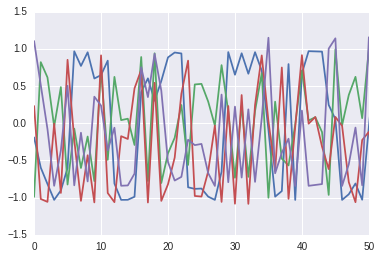

In [261]:
import nibabel as nb

for i in np.arange(1, 5):
    d = nb.load('/home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S01/pnms_to_evs/mapflow/_pnms_to_evs0/pnm_regressors_ev%03d.nii.gz' % i).get_data()
    plt.plot(d[:, :, 0, :].ravel())


plt.xlim(0, 50)

(0, 50)

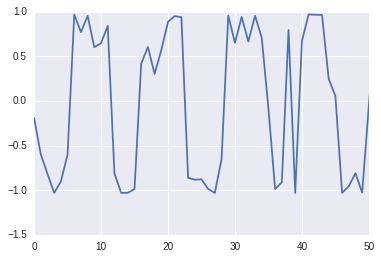

In [251]:
import nipype

In [252]:
nipype.__path__

['/home/gdholla1/git_projects/nipype/nipype']

In [240]:
a= np.loadtxt('/home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S01/get_phys_node/mapflow/_get_phys_node0/physio.txt')

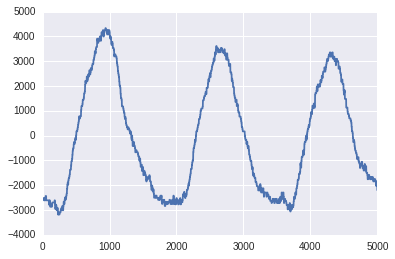

In [246]:
plt.plot(a[:5000, 0])

In [217]:
a.sum(0)

array([  6.69847000e+05,   8.29059220e+07,   1.57300000e+03])

(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.19600000e+03,   6.32200000e+03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.88000000e+02,   3.10000000e+02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

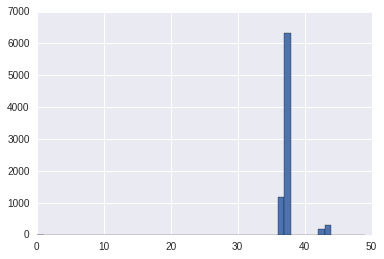

In [46]:
plt.hist(np.diff(gap), bins=np.arange(0, 50))

(array([951166]), array([958666]))

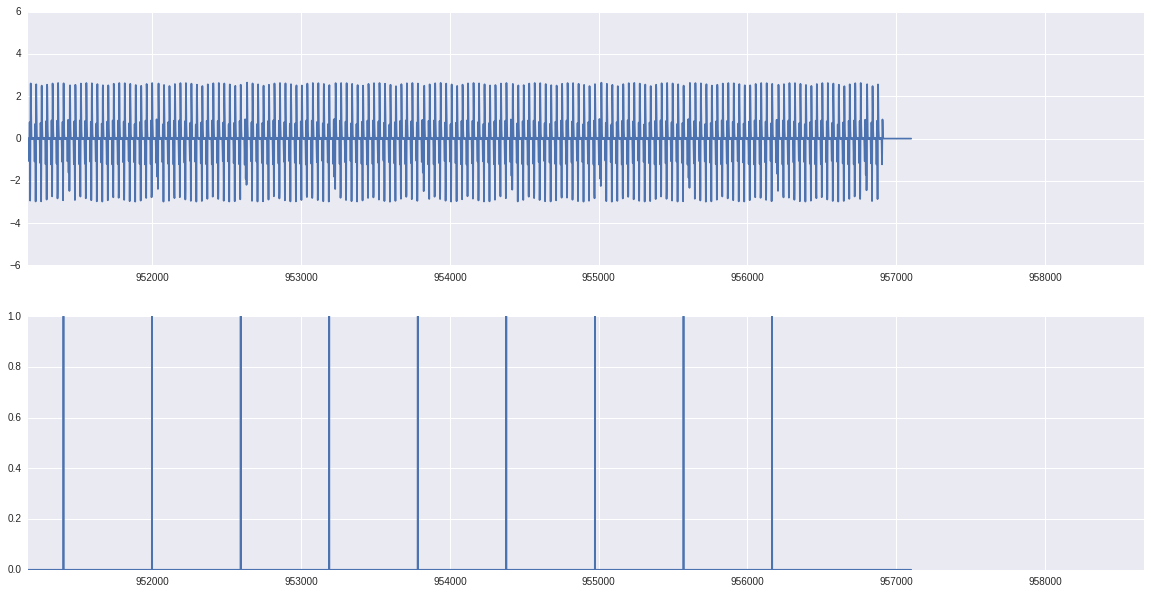

In [31]:
plt.figure(figsize=(20, 10))

idx1 = s.shape - np.argmax(s[::-1]) - 5000
idx2 = idx1 + 7500

plt.subplot(211)
plt.plot(g)
plt.xlim(idx1, idx2)
plt.subplot(212)
plt.plot(s)
plt.xlim(idx1, idx2)

In [205]:
subject_id = 'S01'
run = 3

In [212]:
d = pandas.read_csv('/home/gdholla1/data/daphne/clean/{subject_id}/run{run}.log'.format(**locals()), sep='\s+', header=4)
d.columns = d.columns[1:].tolist() + [np.nan]
print d.isnull().sum(0)
d = d.fillna(method='backfill')
print d.isnull().sum(0)

# gradient_signal = d.ix[:,['gx', 'gy', 'gz']].astype(float).sum(1)
# gradient_signal = (gradient_signal-gradient_signal.mean()) / gradient_signal.std()


v1raw          0
v2raw          1
v1             1
v2             1
ppu            1
resp           1
gx             1
gy             1
gz             1
mark           1
NaN      1495401
dtype: int64
v1raw          0
v2raw          0
v1             0
v2             0
ppu            0
resp           0
gx             0
gy             0
gz             0
mark           0
NaN      1495401
dtype: int64


In [208]:
def get_r2(original, fitted):
    import nibabel as nb
    original = nb.load(original).get_data()
    fitted = nb.load(fitted).get_data()
    
    ss_original = ((original - original.mean(-1)[..., np.newaxis])**2).sum(-1)
    ss_fitted = ((fitted - fitted.mean(-1)[..., np.newaxis])**2).sum(-1)

    r_2 = ss_fitted / ss_original
    
    

,v1raw,v2raw,v1,v2,ppu,resp,gx,gy,gz,mark,nan
0,0,0,3,3,31,-385,0,0,0,0,NaN
1,0,0,3,3,31,-385,0,0,0,0,NaN
2,0,0,3,3,31,-385,0,0,0,0,NaN
3,0,0,2,3,36,-385,0,0,0,0,NaN
4,0,3,2,3,41,-550,0,0,0,0,NaN
5,0,6,2,4,41,-550,0,0,0,0,NaN
6,0,9,2,5,41,-550,0,0,0,0,NaN
7,0,12,2,7,41,-550,0,0,0,0,NaN
8,0,12,2,8,41,-550,0,0,0,0,NaN
9,1,12,2,10,42,-545,0,0,0,0,NaN


In [11]:
import nibabel as nb
fitted = nb.load('fitted.nii.gz').get_data()


In [12]:
original = nb.load('/home/gdholla1/data/daphne/clean/S01/run1.nii.gz').get_data()

In [13]:
fitted.shape

(112, 112, 16, 495)

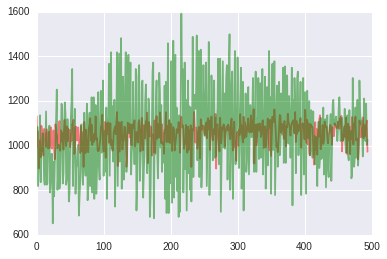

In [23]:

plt.plot(fitted[60, 60, 8, :] + original[60, 60, 8, :].mean(), c='r', alpha=.5)
plt.plot(original[60, 60, 8, :], c='g', alpha=.5)

In [31]:
ss_original = ((original - original.mean(-1)[..., np.newaxis])**2).sum(-1)
ss_fitted = ((fitted - fitted.mean(-1)[..., np.newaxis])**2).sum(-1)

r_2 = ss_fitted / ss_original

(array([  6.77000000e+03,   6.65880000e+04,   5.03670000e+04,
          1.08290000e+04,   9.15000000e+02,   6.10000000e+01,
          1.10000000e+01,   5.00000000e+00,   3.00000000e+00,
          3.00000000e+00]),
 array([ 0.01610003,  0.04242328,  0.06874653,  0.09506978,  0.12139303,
         0.14771628,  0.17403953,  0.20036278,  0.22668603,  0.25300928,
         0.27933253]),
 <a list of 10 Patch objects>)

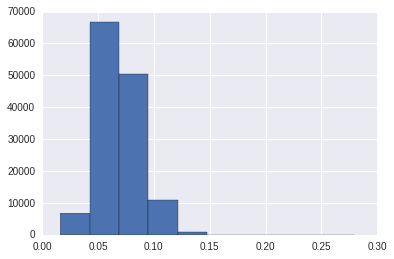

In [36]:
plt.hist(r_2[~np.isnan(r_2)].ravel())

In [37]:
image = nb.load('/home/gdholla1/data/daphne/clean/S01/run1.nii.gz')

In [38]:
nb.save(nb.Nifti1Image(ss_original, image.get_affine()), 'ss_original.nii.gz')
nb.save(nb.Nifti1Image(ss_fitted, image.get_affine()), 'ss_fitted.nii.gz')
nb.save(nb.Nifti1Image(r_2, image.get_affine()), 'r_2.nii.gz')

In [39]:
smoother = fsl.IsotropicSmooth()

In [42]:
smoother.inputs.in_file = 'r_2.nii.gz'
smoother.inputs.fwhm = 3.0

smoother.inputs.out_file = 'r_2_smooth.nii.gz'
r = smoother.run()

In [43]:
r.outputs


out_file = /home/gdholla1/notebooks/2016_daphne/r_2_smooth.nii.gz

In [44]:
image.shape

(112, 112, 16, 495)

In [54]:
resid = nb.load('/home/gdholla1/data/daphne/preprocess_phys/phys_correction/residuals/_subject_id_S03/_get_residuals2/run3_maths_maths.nii.gz').get_data()

In [55]:
resid_ss = ((resid - resid.mean(-1)[..., np.newaxis])**2).sum(-1)

In [56]:
original = nb.load('/home/gdholla1/data/daphne/clean/S03/run3.nii.gz').get_data()

In [57]:
original_ss = ((original - original.mean(-1)[..., np.newaxis])**2).sum(-1)

In [58]:
r2 = (original_ss - resid_ss) / original_ss

(array([  1.35809000e+05,   5.48500000e+03,   1.46700000e+03,
          6.76000000e+02,   4.22000000e+02,   2.53000000e+02,
          1.46000000e+02,   6.00000000e+01,   2.20000000e+01,
          1.10000000e+01]),
 array([ 0.003881  ,  0.07719194,  0.15050289,  0.22381383,  0.29712478,
         0.37043572,  0.44374667,  0.51705761,  0.59036856,  0.6636795 ,
         0.73699045]),
 <a list of 10 Patch objects>)

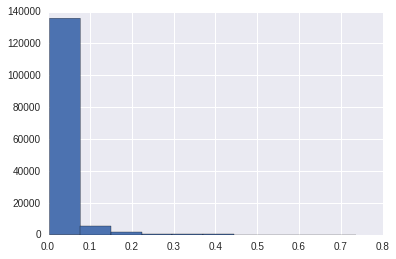

In [59]:
plt.hist(r2[~np.isnan(r2)])

In [60]:
nb.save(nb.Nifti1Image(r2, nb.load('/home/gdholla1/data/daphne/preprocess_phys/phys_correction/residuals/_subject_id_S03/_get_residuals2/run3_maths_maths.nii.gz').get_affine()), 'r2.nii.gz')

In [61]:
import pandas

In [65]:
pandas.Series([1, 2, 3, np.nan, 4]).fillna(method='backfill')

0    1
1    2
2    3
3    4
4    4
dtype: float64

In [70]:
import gzip, pickle as pkl

In [72]:
c = pkl.load(gzip.open('/home/gdholla1/crashdumps/crash-20160519-105419-gdholla1-get_phys_node.a04.pklz'))

In [76]:
n = c['node']

In [87]:
n.run()

Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1118, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 300, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 345, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1043, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1003, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 483, in getmodule
    file = getabsfile(object, _fi

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



IndexError: string index out of range

In [85]:
!rm -rf /home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S08/get_phys_node/

In [78]:
!cat /home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S08/get_phys_node/mapflow/_get_phys_node2/_report/report.rst

Node: utility

 Hierarchy : _get_phys_node2
 Exec ID : _get_phys_node2

Original Inputs
---------------

* fmri_data : /home/gdholla1/data/daphne/clean/S08/run3.nii.gz
* function_str : def get_physiological_regressors(phys_log, fmri_data, nr_dummies=4, threshold=1.5, sample_rate=500, TR=1.2, extra_TRs=2.):
    import pandas
    import nibabel as nb
    import os
    import matplotlib as mpl
    mpl.use('Agg')
    from matplotlib.backends.backend_pdf import PdfPages
    import matplotlib.pyplot as plt
    import numpy as np


    fig_fn = os.path.abspath('physlog_checks.pdf')
    pp = PdfPages(fig_fn)


    d = pandas.read_csv(phys_log, sep='\s+', header=4)
    d.columns = d.columns[1:].tolist() + [np.nan]
    #d = d.fillna(method='backfill')

    gradient_signal = d.ix[:,['gx', 'gy', 'gz']].astype(float).sum(1)
    gradient_signal = (gradient_signal-gradient_signal.mean()) / gradient_signal.std()

    fmri_data = nb.load(fmri_data)
    nr_slices = fmri_data.shape[2]
    nr_TRs = fmri_d

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1503001 but corresponding boolean dimension is 1503000
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1503001 but corresponding boolean dimension is 40064
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1503001 but corresponding boolean dimension is 40064


1501813


('/home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S08/get_phys_node/mapflow/_get_phys_node2/physlog_checks.pdf',
 '/home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S08/get_phys_node/mapflow/_get_phys_node2/physio.txt')

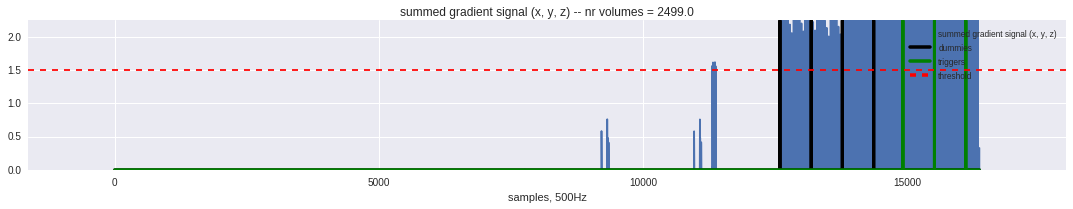

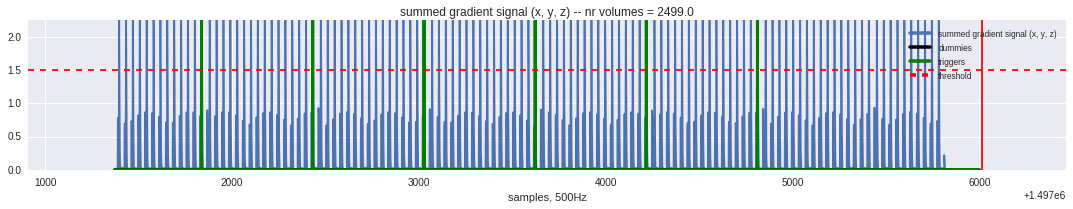

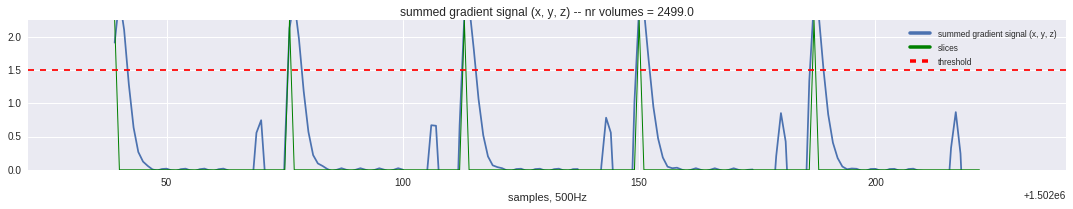

In [80]:
get_physiological_regressors('/home/gdholla1/data/daphne/clean/S08/run3.log', '/home/gdholla1/data/daphne/clean/S08/run3.nii.gz')

In [81]:
s = np.loadtxt('/home/gdholla1/workflow_folders/preprocess_daphne_phys/_subject_id_S08/get_phys_node/mapflow/_get_phys_node2/physio.txt')

(0, 20000)

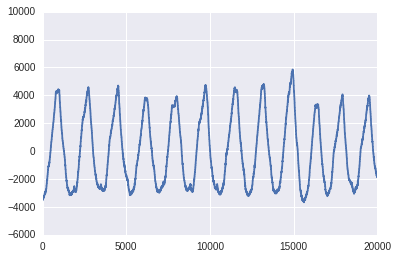

In [84]:
plt.plot(s[:, 0])
plt.xlim(0, 20000)

In [16]:
!cat /home/gdholla1/workflow_folders/preprocess_daphne_phys2/_subject_id_S04/_fwhm_0.0/filter_out_motion/mapflow/_filter_out_motion2/command.txt

sh: 0: getcwd() failed: No such file or directory
fsl_regfilt -i /home/gdholla1/workflow_folders/preprocess_daphne_phys2/featpreproc/_subject_id_S04/_fwhm_0.0/highpass/mapflow/_highpass2/run3_maths_maths_maths_dtype_mcf_mask_gms_tempfilt.nii.gz -o /home/gdholla1/workflow_folders/preprocess_daphne_phys2/_subject_id_S04/_fwhm_0.0/filter_out_motion/mapflow/_filter_out_motion2/run3_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt.nii.gz -d /home/gdholla1/workflow_folders/preprocess_daphne_phys2/_subject_id_S04/_fwhm_0.0/make_motion_regressors/motion_regressor02.txt -f '1,2,3,4,5,6,7,8,9,10,11,12'


In [24]:
np.loadtxt('/home/gdholla1/workflow_folders/preprocess_daphne_phys2/_subject_id_S04/_fwhm_0.0/make_motion_regressors/motion_regressor02.txt').shape

(2316, 12)

(0, 50)

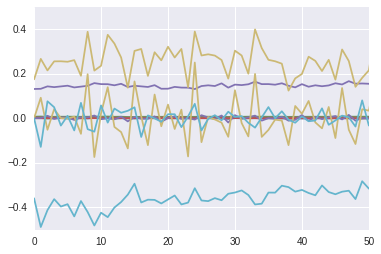

In [22]:
plt.plot(np.loadtxt('/home/gdholla1/workflow_folders/preprocess_daphne_phys2/_subject_id_S04/_fwhm_0.0/make_motion_regressors/motion_regressor02.txt'))

plt.xlim(0, 50)

In [25]:
!fsl_regfilt -i /home/gdholla1/workflow_folders/preprocess_daphne_phys2/featpreproc/_subject_id_S04/_fwhm_0.0/highpass/mapflow/_highpass2/run3_maths_maths_maths_dtype_mcf_mask_gms_tempfilt.nii.gz -o /home/gdholla1/workflow_folders/preprocess_daphne_phys2/_subject_id_S04/_fwhm_0.0/filter_out_motion/mapflow/_filter_out_motion2/run3_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt.nii.gz -d /home/gdholla1/workflow_folders/preprocess_daphne_phys2/_subject_id_S04/_fwhm_0.0/make_motion_regressors/motion_regressor02.txt -f '1,2,3,4,5,6,7,8,9,10,11,12'

sh: 0: getcwd() failed: No such file or directory


In [27]:
!ls -lrt

sh: 0: getcwd() failed: No such file or directory
total 0
